In [1]:
import os

edf_folder = r"E:\sleep_full_dataset"  # Change this to the correct folder path

# Get all files in the folder
all_files = os.listdir(edf_folder)

# Extract PSG and Hypnogram file lists
psg_files = [f for f in all_files if "-PSG.edf" in f]
hypnogram_files = [f for f in all_files if "-Hypnogram.edf" in f]

# Extract subject IDs using only the first 7 characters (e.g., "SC4022")
psg_subjects = {f[:7]: f for f in psg_files}
hypnogram_subjects = {f[:7]: f for f in hypnogram_files}

# Find matching PSG & Hypnogram pairs
matched_files = []
for subject_id, psg_file in psg_subjects.items():
    if subject_id in hypnogram_subjects:
        matched_files.append((psg_file, hypnogram_subjects[subject_id]))
    else:
        print(f"⚠️ Warning: Hypnogram file not found for {psg_file}")

# Print matched PSG-Hypnogram pairs
for psg, hypnogram in matched_files:
    print(f"✅ Matched: {psg} <-> {hypnogram}")

⚠️ Warning: Hypnogram file not found for SC4801G0-PSG.edf
⚠️ Warning: Hypnogram file not found for SC4802G0-PSG.edf
⚠️ Warning: Hypnogram file not found for SC4812G0-PSG.edf
✅ Matched: SC4092E0-PSG.edf <-> SC4092EC-Hypnogram.edf
✅ Matched: SC4101E0-PSG.edf <-> SC4101EC-Hypnogram.edf
✅ Matched: SC4102E0-PSG.edf <-> SC4102EC-Hypnogram.edf
✅ Matched: SC4111E0-PSG.edf <-> SC4111EC-Hypnogram.edf
✅ Matched: SC4112E0-PSG.edf <-> SC4112EC-Hypnogram.edf
✅ Matched: SC4121E0-PSG.edf <-> SC4121EC-Hypnogram.edf
✅ Matched: SC4122E0-PSG.edf <-> SC4122EV-Hypnogram.edf
✅ Matched: SC4131E0-PSG.edf <-> SC4131EC-Hypnogram.edf
✅ Matched: SC4141E0-PSG.edf <-> SC4141EU-Hypnogram.edf
✅ Matched: SC4142E0-PSG.edf <-> SC4142EU-Hypnogram.edf
✅ Matched: SC4151E0-PSG.edf <-> SC4151EC-Hypnogram.edf
✅ Matched: SC4152E0-PSG.edf <-> SC4152EC-Hypnogram.edf
✅ Matched: SC4161E0-PSG.edf <-> SC4161EC-Hypnogram.edf
✅ Matched: SC4162E0-PSG.edf <-> SC4162EC-Hypnogram.edf
✅ Matched: SC4171E0-PSG.edf <-> SC4171EU-Hypnogram.edf
✅

In [5]:
import os
import numpy as np
import pyedflib
from tqdm import tqdm

edf_folder = r"E:\sleep_full_dataset"
output_folder = "processed_epochs"
os.makedirs(output_folder, exist_ok=True)

# Required EEG channels
required_channels = ['EEG Fpz-Cz', 'EEG Pz-Oz']

# Function to extract sleep stage labels from hypnogram
def extract_labels(hypnogram_file):
    edf_reader = pyedflib.EdfReader(hypnogram_file)
    annotations = edf_reader.readAnnotations()
    edf_reader.close()
    
    onset_times = annotations[0]  # Start time of annotation
    durations = annotations[1]    # Duration of annotation
    labels = annotations[2]       # Sleep stage labels

    sleep_stages = []
    for onset, duration, label in zip(onset_times, durations, labels):
        epoch_count = int(duration // 30)  # Number of 30-sec epochs
        sleep_stages.extend([label] * epoch_count)

    return np.array(sleep_stages)

# Process each matched PSG-Hypnogram pair
for psg_file, hypnogram_file in tqdm(matched_files, desc="Processing EEG Data"):
    psg_path = os.path.join(edf_folder, psg_file)
    hypnogram_path = os.path.join(edf_folder, hypnogram_file)

    # Load EEG data from PSG file
    edf_reader = pyedflib.EdfReader(psg_path)
    channel_labels = edf_reader.getSignalLabels()

    # Find indices of required channels
    channel_indices = [channel_labels.index(ch) for ch in required_channels if ch in channel_labels]
    if not channel_indices:
        print(f"Skipping {psg_file}: Required EEG channels not found!")
        edf_reader.close()
        continue

    # Extract EEG signals
    eeg_signals = np.array([edf_reader.readSignal(idx) for idx in channel_indices])
    sampling_rate = edf_reader.getSampleFrequencies()[channel_indices[0]]
    edf_reader.close()

    # Calculate number of samples per 30s epoch
    samples_per_epoch = int(sampling_rate * 30)
    num_epochs = eeg_signals.shape[1] // samples_per_epoch  # Number of full epochs

    # Trim EEG signals to full epochs only
    eeg_epochs = eeg_signals[:, :num_epochs * samples_per_epoch].reshape(num_epochs, len(channel_indices), samples_per_epoch)

    # Extract sleep stage labels
    sleep_labels = extract_labels(hypnogram_path)

    # Ensure sleep labels match the number of epochs
    min_epochs = min(num_epochs, len(sleep_labels))
    eeg_epochs = eeg_epochs[:min_epochs]
    sleep_labels = sleep_labels[:min_epochs]

    # Save processed epochs
    save_path = os.path.join(output_folder, psg_file.replace("-PSG.edf", ".npz"))
    np.savez(save_path, eeg=eeg_epochs, labels=sleep_labels, fs=sampling_rate, channels=required_channels)

    print(f"Processed and saved: {psg_file}")

print("✅ EEG epochs successfully processed and saved with corresponding labels.")

Processing EEG Data:   1%|          | 1/129 [00:11<23:33, 11.05s/it]

Processed and saved: SC4092E0-PSG.edf


Processing EEG Data:   2%|▏         | 2/129 [00:21<22:29, 10.62s/it]

Processed and saved: SC4101E0-PSG.edf


Processing EEG Data:   2%|▏         | 3/129 [00:32<22:57, 10.93s/it]

Processed and saved: SC4102E0-PSG.edf


Processing EEG Data:   3%|▎         | 4/129 [00:42<22:03, 10.59s/it]

Processed and saved: SC4111E0-PSG.edf


Processing EEG Data:   4%|▍         | 5/129 [00:53<21:50, 10.57s/it]

Processed and saved: SC4112E0-PSG.edf


Processing EEG Data:   5%|▍         | 6/129 [01:05<22:53, 11.17s/it]

Processed and saved: SC4121E0-PSG.edf


Processing EEG Data:   5%|▌         | 7/129 [01:17<23:01, 11.33s/it]

Processed and saved: SC4122E0-PSG.edf


Processing EEG Data:   6%|▌         | 8/129 [01:29<23:36, 11.71s/it]

Processed and saved: SC4131E0-PSG.edf


Processing EEG Data:   7%|▋         | 9/129 [01:41<23:43, 11.86s/it]

Processed and saved: SC4141E0-PSG.edf


Processing EEG Data:   8%|▊         | 10/129 [01:54<23:50, 12.02s/it]

Processed and saved: SC4142E0-PSG.edf


Processing EEG Data:   9%|▊         | 11/129 [02:05<23:20, 11.87s/it]

Processed and saved: SC4151E0-PSG.edf


Processing EEG Data:   9%|▉         | 12/129 [02:18<23:41, 12.15s/it]

Processed and saved: SC4152E0-PSG.edf


Processing EEG Data:  10%|█         | 13/129 [02:30<23:11, 11.99s/it]

Processed and saved: SC4161E0-PSG.edf


Processing EEG Data:  11%|█         | 14/129 [02:42<23:09, 12.08s/it]

Processed and saved: SC4162E0-PSG.edf


Processing EEG Data:  12%|█▏        | 15/129 [02:54<22:59, 12.10s/it]

Processed and saved: SC4171E0-PSG.edf


Processing EEG Data:  12%|█▏        | 16/129 [03:06<22:44, 12.07s/it]

Processed and saved: SC4172E0-PSG.edf


Processing EEG Data:  13%|█▎        | 17/129 [03:19<22:39, 12.14s/it]

Processed and saved: SC4181E0-PSG.edf


Processing EEG Data:  14%|█▍        | 18/129 [03:31<22:40, 12.25s/it]

Processed and saved: SC4182E0-PSG.edf


Processing EEG Data:  15%|█▍        | 19/129 [03:43<22:33, 12.30s/it]

Processed and saved: SC4191E0-PSG.edf


Processing EEG Data:  16%|█▌        | 20/129 [03:55<22:04, 12.15s/it]

Processed and saved: SC4192E0-PSG.edf


Processing EEG Data:  16%|█▋        | 21/129 [04:08<22:20, 12.41s/it]

Processed and saved: SC4201E0-PSG.edf


Processing EEG Data:  17%|█▋        | 22/129 [04:20<21:59, 12.34s/it]

Processed and saved: SC4202E0-PSG.edf


Processing EEG Data:  18%|█▊        | 23/129 [04:34<22:16, 12.61s/it]

Processed and saved: SC4211E0-PSG.edf


Processing EEG Data:  19%|█▊        | 24/129 [04:47<22:10, 12.67s/it]

Processed and saved: SC4212E0-PSG.edf


Processing EEG Data:  19%|█▉        | 25/129 [04:59<21:49, 12.59s/it]

Processed and saved: SC4221E0-PSG.edf


Processing EEG Data:  20%|██        | 26/129 [05:11<21:35, 12.58s/it]

Processed and saved: SC4222E0-PSG.edf


Processing EEG Data:  21%|██        | 27/129 [05:24<21:28, 12.64s/it]

Processed and saved: SC4231E0-PSG.edf


Processing EEG Data:  22%|██▏       | 28/129 [05:37<21:12, 12.59s/it]

Processed and saved: SC4232E0-PSG.edf


Processing EEG Data:  22%|██▏       | 29/129 [05:49<20:47, 12.48s/it]

Processed and saved: SC4241E0-PSG.edf


Processing EEG Data:  23%|██▎       | 30/129 [06:01<20:18, 12.31s/it]

Processed and saved: SC4242E0-PSG.edf


Processing EEG Data:  24%|██▍       | 31/129 [06:13<20:09, 12.34s/it]

Processed and saved: SC4251E0-PSG.edf


Processing EEG Data:  25%|██▍       | 32/129 [06:25<19:39, 12.16s/it]

Processed and saved: SC4252E0-PSG.edf


Processing EEG Data:  26%|██▌       | 33/129 [06:38<19:42, 12.32s/it]

Processed and saved: SC4261F0-PSG.edf


Processing EEG Data:  26%|██▋       | 34/129 [06:50<19:29, 12.31s/it]

Processed and saved: SC4262F0-PSG.edf


Processing EEG Data:  27%|██▋       | 35/129 [07:01<18:37, 11.89s/it]

Processed and saved: SC4271F0-PSG.edf


Processing EEG Data:  28%|██▊       | 36/129 [07:14<18:47, 12.12s/it]

Processed and saved: SC4272F0-PSG.edf


Processing EEG Data:  29%|██▊       | 37/129 [07:26<18:45, 12.23s/it]

Processed and saved: SC4281G0-PSG.edf


Processing EEG Data:  29%|██▉       | 38/129 [07:38<18:37, 12.28s/it]

Processed and saved: SC4282G0-PSG.edf


Processing EEG Data:  30%|███       | 39/129 [07:51<18:22, 12.25s/it]

Processed and saved: SC4291G0-PSG.edf


Processing EEG Data:  31%|███       | 40/129 [08:03<18:14, 12.29s/it]

Processed and saved: SC4292G0-PSG.edf


Processing EEG Data:  32%|███▏      | 41/129 [08:15<17:47, 12.13s/it]

Processed and saved: SC4311E0-PSG.edf


Processing EEG Data:  33%|███▎      | 42/129 [08:27<17:35, 12.13s/it]

Processed and saved: SC4312E0-PSG.edf


Processing EEG Data:  33%|███▎      | 43/129 [08:39<17:27, 12.18s/it]

Processed and saved: SC4321E0-PSG.edf


Processing EEG Data:  34%|███▍      | 44/129 [08:52<17:27, 12.33s/it]

Processed and saved: SC4331F0-PSG.edf


Processing EEG Data:  35%|███▍      | 45/129 [09:04<17:17, 12.36s/it]

Processed and saved: SC4332F0-PSG.edf


Processing EEG Data:  36%|███▌      | 46/129 [09:17<17:04, 12.35s/it]

Processed and saved: SC4341F0-PSG.edf


Processing EEG Data:  36%|███▋      | 47/129 [09:29<16:50, 12.33s/it]

Processed and saved: SC4342F0-PSG.edf


Processing EEG Data:  37%|███▋      | 48/129 [09:41<16:32, 12.26s/it]

Processed and saved: SC4351F0-PSG.edf


Processing EEG Data:  38%|███▊      | 49/129 [09:52<15:56, 11.96s/it]

Processed and saved: SC4352F0-PSG.edf


Processing EEG Data:  39%|███▉      | 50/129 [10:00<13:55, 10.57s/it]

Processed and saved: SC4362F0-PSG.edf


Processing EEG Data:  40%|███▉      | 51/129 [10:12<14:37, 11.25s/it]

Processed and saved: SC4371F0-PSG.edf


Processing EEG Data:  40%|████      | 52/129 [10:25<14:55, 11.62s/it]

Processed and saved: SC4372F0-PSG.edf


Processing EEG Data:  41%|████      | 53/129 [10:37<14:57, 11.80s/it]

Processed and saved: SC4381F0-PSG.edf


Processing EEG Data:  42%|████▏     | 54/129 [10:50<14:58, 11.98s/it]

Processed and saved: SC4382F0-PSG.edf


Processing EEG Data:  43%|████▎     | 55/129 [11:01<14:42, 11.93s/it]

Processed and saved: SC4401E0-PSG.edf


Processing EEG Data:  43%|████▎     | 56/129 [11:14<14:46, 12.15s/it]

Processed and saved: SC4402E0-PSG.edf


Processing EEG Data:  44%|████▍     | 57/129 [11:26<14:35, 12.15s/it]

Processed and saved: SC4411E0-PSG.edf


Processing EEG Data:  45%|████▍     | 58/129 [11:39<14:31, 12.28s/it]

Processed and saved: SC4412E0-PSG.edf


Processing EEG Data:  46%|████▌     | 59/129 [11:51<14:22, 12.32s/it]

Processed and saved: SC4421E0-PSG.edf


Processing EEG Data:  47%|████▋     | 60/129 [12:04<14:13, 12.36s/it]

Processed and saved: SC4422E0-PSG.edf


Processing EEG Data:  47%|████▋     | 61/129 [12:16<14:09, 12.49s/it]

Processed and saved: SC4431E0-PSG.edf


Processing EEG Data:  48%|████▊     | 62/129 [12:29<13:58, 12.52s/it]

Processed and saved: SC4432E0-PSG.edf


Processing EEG Data:  49%|████▉     | 63/129 [12:41<13:29, 12.27s/it]

Processed and saved: SC4441E0-PSG.edf


Processing EEG Data:  50%|████▉     | 64/129 [12:53<13:22, 12.34s/it]

Processed and saved: SC4442E0-PSG.edf


Processing EEG Data:  50%|█████     | 65/129 [13:06<13:10, 12.35s/it]

Processed and saved: SC4451F0-PSG.edf


Processing EEG Data:  51%|█████     | 66/129 [13:17<12:50, 12.22s/it]

Processed and saved: SC4452F0-PSG.edf


Processing EEG Data:  52%|█████▏    | 67/129 [13:30<12:35, 12.18s/it]

Processed and saved: SC4461F0-PSG.edf


Processing EEG Data:  53%|█████▎    | 68/129 [13:42<12:33, 12.35s/it]

Processed and saved: SC4462F0-PSG.edf


Processing EEG Data:  53%|█████▎    | 69/129 [13:54<12:17, 12.29s/it]

Processed and saved: SC4471F0-PSG.edf


Processing EEG Data:  54%|█████▍    | 70/129 [14:07<12:08, 12.34s/it]

Processed and saved: SC4472F0-PSG.edf


Processing EEG Data:  55%|█████▌    | 71/129 [14:20<12:04, 12.49s/it]

Processed and saved: SC4481F0-PSG.edf


Processing EEG Data:  56%|█████▌    | 72/129 [14:33<11:58, 12.60s/it]

Processed and saved: SC4482F0-PSG.edf


Processing EEG Data:  57%|█████▋    | 73/129 [14:45<11:46, 12.62s/it]

Processed and saved: SC4491G0-PSG.edf


Processing EEG Data:  57%|█████▋    | 74/129 [14:55<10:43, 11.70s/it]

Processed and saved: SC4492G0-PSG.edf


Processing EEG Data:  58%|█████▊    | 75/129 [15:07<10:41, 11.87s/it]

Processed and saved: SC4501E0-PSG.edf


Processing EEG Data:  59%|█████▉    | 76/129 [15:19<10:34, 11.98s/it]

Processed and saved: SC4502E0-PSG.edf


Processing EEG Data:  60%|█████▉    | 77/129 [15:31<10:25, 12.03s/it]

Processed and saved: SC4511E0-PSG.edf


Processing EEG Data:  60%|██████    | 78/129 [15:44<10:18, 12.14s/it]

Processed and saved: SC4512E0-PSG.edf


Processing EEG Data:  61%|██████    | 79/129 [15:56<10:11, 12.23s/it]

Processed and saved: SC4522E0-PSG.edf


Processing EEG Data:  62%|██████▏   | 80/129 [16:08<09:48, 12.01s/it]

Processed and saved: SC4531E0-PSG.edf


Processing EEG Data:  63%|██████▎   | 81/129 [16:20<09:37, 12.02s/it]

Processed and saved: SC4532E0-PSG.edf


Processing EEG Data:  64%|██████▎   | 82/129 [16:32<09:28, 12.09s/it]

Processed and saved: SC4541F0-PSG.edf


Processing EEG Data:  64%|██████▍   | 83/129 [16:44<09:17, 12.12s/it]

Processed and saved: SC4542F0-PSG.edf


Processing EEG Data:  65%|██████▌   | 84/129 [16:57<09:13, 12.30s/it]

Processed and saved: SC4551F0-PSG.edf


Processing EEG Data:  66%|██████▌   | 85/129 [17:10<09:06, 12.43s/it]

Processed and saved: SC4552F0-PSG.edf


Processing EEG Data:  67%|██████▋   | 86/129 [17:22<08:53, 12.40s/it]

Processed and saved: SC4561F0-PSG.edf


Processing EEG Data:  67%|██████▋   | 87/129 [17:35<08:45, 12.52s/it]

Processed and saved: SC4562F0-PSG.edf


Processing EEG Data:  68%|██████▊   | 88/129 [17:48<08:35, 12.57s/it]

Processed and saved: SC4571F0-PSG.edf


Processing EEG Data:  69%|██████▉   | 89/129 [18:00<08:26, 12.66s/it]

Processed and saved: SC4572F0-PSG.edf


Processing EEG Data:  70%|██████▉   | 90/129 [18:13<08:11, 12.60s/it]

Processed and saved: SC4581G0-PSG.edf


Processing EEG Data:  71%|███████   | 91/129 [18:25<07:50, 12.38s/it]

Processed and saved: SC4582G0-PSG.edf


Processing EEG Data:  71%|███████▏  | 92/129 [18:37<07:41, 12.46s/it]

Processed and saved: SC4591G0-PSG.edf


Processing EEG Data:  72%|███████▏  | 93/129 [18:46<06:50, 11.41s/it]

Processed and saved: SC4592G0-PSG.edf


Processing EEG Data:  73%|███████▎  | 94/129 [18:59<06:50, 11.73s/it]

Processed and saved: SC4601E0-PSG.edf


Processing EEG Data:  74%|███████▎  | 95/129 [19:11<06:45, 11.94s/it]

Processed and saved: SC4602E0-PSG.edf


Processing EEG Data:  74%|███████▍  | 96/129 [19:23<06:31, 11.87s/it]

Processed and saved: SC4611E0-PSG.edf


Processing EEG Data:  75%|███████▌  | 97/129 [19:35<06:21, 11.91s/it]

Processed and saved: SC4612E0-PSG.edf


Processing EEG Data:  76%|███████▌  | 98/129 [19:47<06:05, 11.79s/it]

Processed and saved: SC4621E0-PSG.edf


Processing EEG Data:  77%|███████▋  | 99/129 [19:59<06:02, 12.07s/it]

Processed and saved: SC4622E0-PSG.edf


Processing EEG Data:  78%|███████▊  | 100/129 [20:11<05:50, 12.08s/it]

Processed and saved: SC4631E0-PSG.edf


Processing EEG Data:  78%|███████▊  | 101/129 [20:24<05:43, 12.26s/it]

Processed and saved: SC4632E0-PSG.edf


Processing EEG Data:  79%|███████▉  | 102/129 [20:36<05:27, 12.14s/it]

Processed and saved: SC4641E0-PSG.edf


Processing EEG Data:  80%|███████▉  | 103/129 [20:49<05:19, 12.30s/it]

Processed and saved: SC4651E0-PSG.edf


Processing EEG Data:  81%|████████  | 104/129 [21:01<05:09, 12.38s/it]

Processed and saved: SC4652E0-PSG.edf


Processing EEG Data:  81%|████████▏ | 105/129 [21:13<04:55, 12.29s/it]

Processed and saved: SC4661E0-PSG.edf


Processing EEG Data:  82%|████████▏ | 106/129 [21:26<04:43, 12.32s/it]

Processed and saved: SC4662E0-PSG.edf


Processing EEG Data:  83%|████████▎ | 107/129 [21:38<04:30, 12.31s/it]

Processed and saved: SC4671G0-PSG.edf


Processing EEG Data:  84%|████████▎ | 108/129 [21:49<04:13, 12.08s/it]

Processed and saved: SC4672G0-PSG.edf


Processing EEG Data:  84%|████████▍ | 109/129 [22:01<04:00, 12.03s/it]

Processed and saved: SC4701E0-PSG.edf


Processing EEG Data:  85%|████████▌ | 110/129 [22:13<03:46, 11.91s/it]

Processed and saved: SC4702E0-PSG.edf


Processing EEG Data:  86%|████████▌ | 111/129 [22:25<03:35, 11.96s/it]

Processed and saved: SC4711E0-PSG.edf


Processing EEG Data:  87%|████████▋ | 112/129 [22:38<03:26, 12.14s/it]

Processed and saved: SC4712E0-PSG.edf


Processing EEG Data:  88%|████████▊ | 113/129 [22:48<03:06, 11.66s/it]

Processed and saved: SC4721E0-PSG.edf


Processing EEG Data:  88%|████████▊ | 114/129 [23:00<02:57, 11.81s/it]

Processed and saved: SC4722E0-PSG.edf


Processing EEG Data:  89%|████████▉ | 115/129 [23:13<02:47, 11.98s/it]

Processed and saved: SC4731E0-PSG.edf


Processing EEG Data:  90%|████████▉ | 116/129 [23:24<02:32, 11.70s/it]

Processed and saved: SC4732E0-PSG.edf


Processing EEG Data:  91%|█████████ | 117/129 [23:36<02:20, 11.74s/it]

Processed and saved: SC4751E0-PSG.edf


Processing EEG Data:  91%|█████████▏| 118/129 [23:46<02:05, 11.37s/it]

Processed and saved: SC4811G0-PSG.edf


Processing EEG Data:  92%|█████████▏| 119/129 [23:58<01:55, 11.58s/it]

Processed and saved: SC4821G0-PSG.edf


Processing EEG Data:  93%|█████████▎| 120/129 [24:11<01:46, 11.85s/it]

Processed and saved: SC4822G0-PSG.edf


Processing EEG Data:  94%|█████████▍| 121/129 [24:21<01:30, 11.34s/it]

Processed and saved: ST7192J0-PSG.edf


Processing EEG Data:  95%|█████████▍| 122/129 [24:30<01:14, 10.60s/it]

Processed and saved: ST7201J0-PSG.edf


Processing EEG Data:  95%|█████████▌| 123/129 [24:39<01:00, 10.16s/it]

Processed and saved: ST7202J0-PSG.edf


Processing EEG Data:  96%|█████████▌| 124/129 [24:49<00:50, 10.08s/it]

Processed and saved: ST7211J0-PSG.edf


Processing EEG Data:  97%|█████████▋| 125/129 [24:58<00:39,  9.93s/it]

Processed and saved: ST7212J0-PSG.edf


Processing EEG Data:  98%|█████████▊| 126/129 [25:08<00:29,  9.99s/it]

Processed and saved: ST7221J0-PSG.edf


Processing EEG Data:  98%|█████████▊| 127/129 [25:17<00:19,  9.63s/it]

Processed and saved: ST7222J0-PSG.edf


Processing EEG Data:  99%|█████████▉| 128/129 [25:27<00:09,  9.75s/it]

Processed and saved: ST7241J0-PSG.edf


Processing EEG Data: 100%|██████████| 129/129 [25:36<00:00, 11.91s/it]

Processed and saved: ST7242J0-PSG.edf
✅ EEG epochs successfully processed and saved with corresponding labels.


In [4]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA RTX A6000
Using device: cuda


In [6]:
import os
import numpy as np
import scipy.signal
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder 

# Path to processed EEG epochs
data_folder = "processed_epochs"

# Function to compute power spectral density (PSD) features
def extract_psd_features(eeg_epoch, fs):
    freqs, psd = scipy.signal.welch(eeg_epoch, fs=fs, nperseg=fs*2)  # Compute PSD
    psd = np.log1p(psd)  # Use log1p to avoid log(0) issues
    return psd.flatten()


X = []
y = []

for file in os.listdir(data_folder):
    if file.endswith(".npz"):
        data = np.load(os.path.join(data_folder, file))
        eeg_epochs = data["eeg"]  # Shape: (num_epochs, num_channels, samples_per_epoch)
        labels = data["labels"]
        fs = data["fs"]

        # Extract PSD features for each epoch
        for i in range(eeg_epochs.shape[0]):
            features = np.hstack([extract_psd_features(eeg_epochs[i, ch], fs) for ch in range(eeg_epochs.shape[1])])
            X.append(features)
            y.append(labels[i])

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)


if np.isnan(X).any() or np.isinf(X).any():
    print("Warning: NaN or Inf detected in feature matrix! Replacing with zero.")
    X = np.nan_to_num(X)  # Replace NaN and Inf with zero

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


model = keras.Sequential([
    layers.Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(len(np.unique(y)), activation="softmax")  # Output layer (num classes)
])

# Compile model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
y_pred = np.argmax(model.predict(X_test), axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Epoch 1/30
8391/8391 [==============================] - 26s 3ms/step - loss: 1.0192 - accuracy: 0.6688 - val_loss: 0.9983 - val_accuracy: 0.6696
Epoch 2/30
8391/8391 [==============================] - 28s 3ms/step - loss: 0.9877 - accuracy: 0.6712 - val_loss: 0.9766 - val_accuracy: 0.6730
Epoch 3/30
8391/8391 [==============================] - 28s 3ms/step - loss: 0.9728 - accuracy: 0.6729 - val_loss: 0.9792 - val_accuracy: 0.6727
Epoch 4/30
8391/8391 [==============================] - 28s 3ms/step - loss: 0.9615 - accuracy: 0.6748 - val_loss: 0.9576 - val_accuracy: 0.6755
Epoch 5/30
8391/8391 [==============================] - 28s 3ms/step - loss: 0.9539 - accuracy: 0.6763 - val_loss: 0.9604 - val_accuracy: 0.6749
Epoch 6/30
8391/8391 [==============================] - 28s 3ms/step - loss: 0.9479 - accuracy: 0.6777 - val_loss: 0.9514 - val_accuracy: 0.6763
Epoch 7/30
8391/8391 [==============================] - 28s 3ms/step - loss: 0.9420 - accuracy: 0.6788 - val_loss: 0.9445 - val_ac

c:\Users\gpu.arl\.conda\envs\2448507\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gpu.arl\.conda\envs\2448507\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gpu.arl\.conda\envs\2448507\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [7]:
import scipy.signal
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Path to processed EEG epochs
data_folder = "processed_epochs"

# Function to compute power spectral density (PSD) features
def extract_psd_features(eeg_epoch, fs):
    freqs, psd = scipy.signal.welch(eeg_epoch, fs=fs, nperseg=fs*2)  # Compute PSD
    psd = np.log1p(psd)  # Use log1p to avoid log(0) issues
    return psd.flatten()

# Function to compute Short-Time Fourier Transform (STFT) features
def extract_stft_features(eeg_epoch, fs):
    f, t, Zxx = scipy.signal.stft(eeg_epoch, fs=fs, nperseg=fs//2)
    stft_magnitude = np.abs(Zxx)  # Extract magnitude
    return stft_magnitude.flatten()

X = []
y = []

for file in os.listdir(data_folder):
    if file.endswith(".npz"):
        data = np.load(os.path.join(data_folder, file))
        eeg_epochs = data["eeg"]  # Shape: (num_epochs, num_channels, samples_per_epoch)
        labels = data["labels"]
        fs = data["fs"]

        # Extract PSD and STFT features for each epoch
        for i in range(eeg_epochs.shape[0]):
            psd_features = np.hstack([extract_psd_features(eeg_epochs[i, ch], fs) for ch in range(eeg_epochs.shape[1])])
            stft_features = np.hstack([extract_stft_features(eeg_epochs[i, ch], fs) for ch in range(eeg_epochs.shape[1])])

            # Combine features
            combined_features = np.hstack((psd_features, stft_features))

            X.append(combined_features)
            y.append(labels[i])

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

# Handle NaN/Inf values
if np.isnan(X).any() or np.isinf(X).any():
    print("Warning: NaN or Inf detected in feature matrix! Replacing with zero.")
    X = np.nan_to_num(X)  # Replace NaN and Inf with zero

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define MLP Model
model = keras.Sequential([
    layers.Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(len(np.unique(y)), activation="softmax")  # Output layer (num classes)
])

# Compile model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
y_pred = np.argmax(model.predict(X_test), axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

import matplotlib.pyplot as plt

# Plot training & validation accuracy
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)  # Create a subplot for accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Test Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid()

# Loss Plot
plt.subplot(1, 2, 2)  # Create a subplot for loss
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Test Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

just lstm

Epoch 1/20
8391/8391 [==============================] - 61s 7ms/step - loss: 1.0656 - accuracy: 0.6677 - val_loss: 1.0976 - val_accuracy: 0.6679
Epoch 2/20
8391/8391 [==============================] - 58s 7ms/step - loss: 1.0569 - accuracy: 0.6679 - val_loss: 1.0935 - val_accuracy: 0.6679
Epoch 3/20
8391/8391 [==============================] - 58s 7ms/step - loss: 1.0488 - accuracy: 0.6680 - val_loss: 1.1344 - val_accuracy: 0.6499
Epoch 4/20
8391/8391 [==============================] - 58s 7ms/step - loss: 1.0327 - accuracy: 0.6695 - val_loss: 1.2114 - val_accuracy: 0.6274
Epoch 5/20
8391/8391 [==============================] - 59s 7ms/step - loss: 1.0100 - accuracy: 0.6724 - val_loss: 1.2259 - val_accuracy: 0.6404
Epoch 6/20
8391/8391 [==============================] - 59s 7ms/step - loss: 0.9843 - accuracy: 0.6772 - val_loss: 1.3558 - val_accuracy: 0.6263
Epoch 7/20
8391/8391 [==============================] - 59s 7ms/step - loss: 0.9588 - accuracy: 0.6826 - val_loss: 1.3398 - val_ac

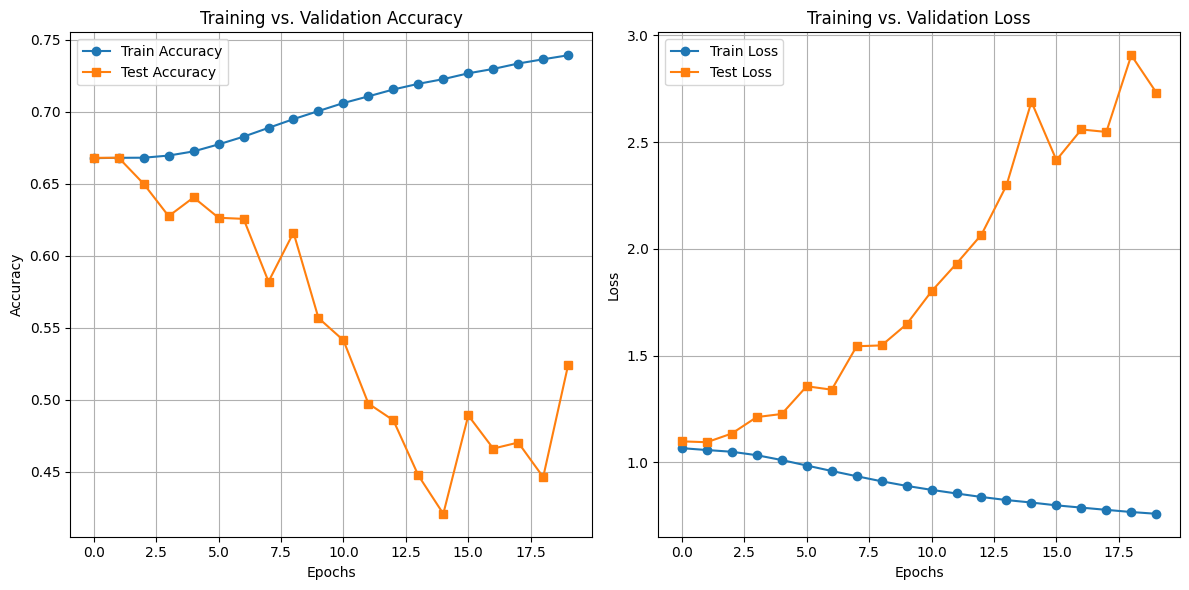

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import os

# Path to processed EEG epochs
data_folder = "processed_epochs"

# Function to compute power spectral density (PSD) features
def extract_psd_features(eeg_epoch, fs):
    freqs, psd = scipy.signal.welch(eeg_epoch, fs=fs, nperseg=fs*2)  
    psd = np.log1p(psd)  # Log transform to avoid log(0) issues
    return psd.flatten()

X = []
y = []

for file in os.listdir(data_folder):
    if file.endswith(".npz"):
        data = np.load(os.path.join(data_folder, file))
        eeg_epochs = data["eeg"]  # Shape: (num_epochs, num_channels, samples_per_epoch)
        labels = data["labels"]
        fs = data["fs"]

        # Extract PSD features for each epoch
        for i in range(eeg_epochs.shape[0]):
            features = np.array([extract_psd_features(eeg_epochs[i, ch], fs) for ch in range(eeg_epochs.shape[1])])
            X.append(features)
            y.append(labels[i])

# Convert to NumPy arrays
X = np.array(X)  # Shape: (num_samples, num_channels, num_features)
y = np.array(y)

# Handle NaN/Inf values
if np.isnan(X).any() or np.isinf(X).any():
    print("Warning: NaN or Inf detected in feature matrix! Replacing with zero.")
    X = np.nan_to_num(X)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize features
scaler = StandardScaler()
X_train = np.array([scaler.fit_transform(sample) for sample in X_train])
X_test = np.array([scaler.transform(sample) for sample in X_test])

# Define LSTM Model
model = Sequential([
    layers.LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.LSTM(64),
    layers.Dense(32, activation="relu"),
    layers.Dense(len(np.unique(y)), activation="softmax")  # Output layer (num classes)
])

# Compile model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
y_pred = np.argmax(model.predict(X_test), axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot training vs validation accuracy
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)  # Create a subplot for accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Test Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid()

# Loss Plot
plt.subplot(1, 2, 2)  # Create a subplot for loss
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Test Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()

lstm with regularization

Epoch 1/10
4196/4196 [==============================] - 65s 15ms/step - loss: 1.2780 - accuracy: 0.6607 - val_loss: 1.0845 - val_accuracy: 0.6679
Epoch 2/10
4196/4196 [==============================] - 63s 15ms/step - loss: 1.0706 - accuracy: 0.6679 - val_loss: 1.0752 - val_accuracy: 0.6679
Epoch 3/10
4196/4196 [==============================] - 63s 15ms/step - loss: 1.0693 - accuracy: 0.6679 - val_loss: 1.0847 - val_accuracy: 0.6679
Epoch 4/10
4196/4196 [==============================] - 63s 15ms/step - loss: 1.0680 - accuracy: 0.6679 - val_loss: 1.0714 - val_accuracy: 0.6679
Epoch 5/10
4196/4196 [==============================] - 63s 15ms/step - loss: 1.0670 - accuracy: 0.6679 - val_loss: 1.0723 - val_accuracy: 0.6679
Epoch 6/10
4196/4196 [==============================] - 63s 15ms/step - loss: 1.0668 - accuracy: 0.6679 - val_loss: 1.1108 - val_accuracy: 0.6679
Epoch 7/10
4196/4196 [==============================] - 63s 15ms/step - loss: 1.0663 - accuracy: 0.6679 - val_loss: 1.0776 -

c:\Users\gpu.arl\.conda\envs\2448507\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gpu.arl\.conda\envs\2448507\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gpu.arl\.conda\envs\2448507\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


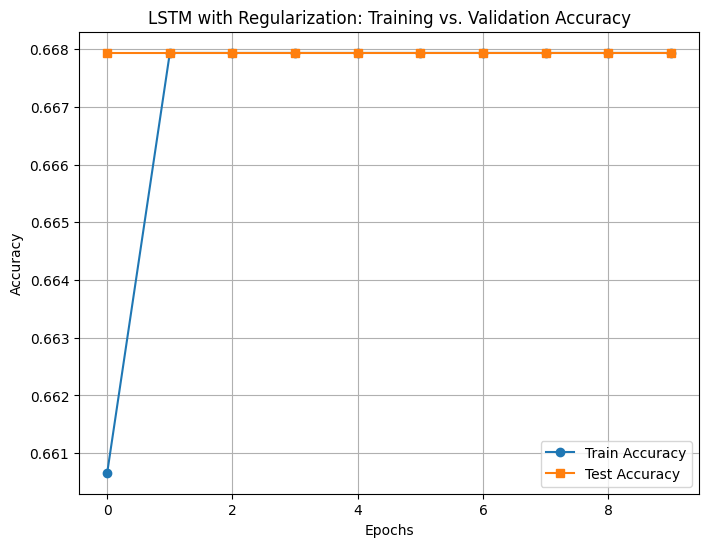

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import os

# Path to processed EEG epochs
data_folder = "processed_epochs"

# Function to compute power spectral density (PSD) features
def extract_psd_features(eeg_epoch, fs):
    freqs, psd = scipy.signal.welch(eeg_epoch, fs=fs, nperseg=fs*2)  
    psd = np.log1p(psd)  # Log transform to avoid log(0) issues
    return psd.flatten()

X = []
y = []

for file in os.listdir(data_folder):
    if file.endswith(".npz"):
        data = np.load(os.path.join(data_folder, file))
        eeg_epochs = data["eeg"]  
        labels = data["labels"]
        fs = data["fs"]

        # Extract PSD features for each epoch
        for i in range(eeg_epochs.shape[0]):
            features = np.array([extract_psd_features(eeg_epochs[i, ch], fs) for ch in range(eeg_epochs.shape[1])])
            X.append(features)
            y.append(labels[i])

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Handle NaN/Inf values
if np.isnan(X).any() or np.isinf(X).any():
    print("Warning: NaN or Inf detected in feature matrix! Replacing with zero.")
    X = np.nan_to_num(X)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize features
scaler = StandardScaler()
X_train = np.array([scaler.fit_transform(sample) for sample in X_train])
X_test = np.array([scaler.transform(sample) for sample in X_test])

# Define LSTM Model with Regularization
model = Sequential([
    layers.LSTM(64, return_sequences=True, 
                kernel_regularizer=regularizers.l2(0.01), 
                recurrent_regularizer=regularizers.l2(0.01),
                input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.BatchNormalization(),
    layers.Dropout(0.3),  
    
    layers.LSTM(32, return_sequences=False, 
                kernel_regularizer=regularizers.l2(0.01),
                recurrent_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),  
    
    layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),
    
    layers.Dense(len(np.unique(y)), activation="softmax")
])

# Compile model with Gradient Clipping
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)

model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Evaluate model
y_pred = np.argmax(model.predict(X_test), axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot training vs validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Test Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('LSTM with Regularization: Training vs. Validation Accuracy')
plt.legend()
plt.grid()
plt.show()